In [20]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

from utilities2015 import *

from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import average, fcluster, single, complete

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.measure import find_contours
from skimage.util import img_as_float

import matplotlib.pyplot as plt
%matplotlib inline

from networkx import from_dict_of_lists, Graph, adjacency_matrix, connected_components
from networkx.algorithms import node_connected_component, dfs_successors, dfs_postorder_nodes

In [ ]:
stack_name = 'MD593'
section_id = 98
# dm = DataManager(stack=stack_name, section=section_id, segm_params_id='gridsize200')
dm = DataManager(stack=stack_name, section=section_id, segm_params_id='tSLIC200')

In [31]:
dm.load_multiple_results(results=['texHist', 'segmentation', 'texMap', 'neighbors', 
                                  'edgeCoords', 'spCentroids', 'edge_neighbors', 'dedge_neighbors'])

In [11]:
def compute_nearest_surround(cluster, neighbors, texton_hists):
    cluster_list = list(cluster)
    cluster_avg = texton_hists[cluster_list].mean(axis=0)    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    surrounds_list = list(surrounds)
    ds = np.squeeze(chi2s([cluster_avg], texton_hists[surrounds_list]))     
    surround_dist = ds.min()
    return surrounds_list[ds.argmin()]


def compute_cluster_score(cluster, neighbors, texton_hists, verbose=False, thresh=.2):
    
    cluster_list = list(cluster)
    cluster_avg = texton_hists[cluster_list].mean(axis=0)
    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    if len(surrounds) == 0: # single sp on background
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    surrounds_list = list(surrounds)
        
#     ds = np.squeeze(chi2s([cluster_avg], texton_hists[surrounds_list])) 
    ds = np.squeeze(cdist([cluster_avg], texton_hists[surrounds_list], chi2))
#     ds = np.squeeze(cdist([cluster_avg], texton_hists[surrounds_list], kl))
    
#     sur_hists = [texton_hists[list(neighbors[s])].mean(axis=0) for s in surrounds_list]
#     ds = np.squeeze(cdist([cluster_avg], sur_hists, chi2))
    
#     thresh = .2
    surround_dist = np.count_nonzero(ds > thresh) / float(len(ds)) # hard

#     sigma = .01
#     surround_dist = np.sum(1./(1+np.exp((thresh - ds)/sigma)))/len(ds); #soft

#     surround_dist = ds.min()
    if verbose:
        print 'min', surrounds_list[ds.argmin()]

#     surds, _ = find_boundary_sps([cluster], neighbors=neighbors, neighbor_graph=neighbor_graph)
    
#     compactness = len(surds[0])**2/float(len(cluster))
#     compactness = .001 * np.maximum(compactness-40,0)**2
    
#     size_prior = .1 * (1-np.exp(-.8*len(cluster)))
    
#     score = surround_dist - compactness + size_prior
    score = surround_dist
    
    if len(cluster) > 1:
        ds = np.squeeze(chi2s([cluster_avg], texton_hists[list(cluster)]))
        var = ds.mean()
#         var = np.sum(ds**2)/len(ds)
    else:
        var = 0
    
    interior_dist = np.nan
    compactness = np.nan
    interior_pval = np.nan
    surround_pval = np.nan
    size_prior = np.nan
    
    return score, surround_dist, var, compactness, surround_pval, interior_pval, size_prior

In [12]:
def find_score_peaks(scores, min_size = 4, min_distance=10, threshold_rel=.3, threshold_abs=0, peakedness_lim=.001,
                    peakedness_radius=5):
    
    if len(scores) > min_size + 1:
    
        peaks = peak_local_max(scores[min_size-1:]-scores[min_size-1:].min(), min_distance=min_distance, 
                                      threshold_rel=threshold_rel, exclude_border=False)
                
        print peaks
        
        if len(peaks) > 0:
            peaks = min_size-1 + peaks.T
            peaks = peaks[0]

            peakedness = np.array([scores[p]-np.mean(np.r_[scores[p-peakedness_radius:p], 
                                                           scores[p+1:p+1+peakedness_radius]]) for p in peaks])

            peaks = peaks[peakedness > peakedness_lim]
            peakedness = peakedness[peakedness > peakedness_lim]

            peaks_sorted = peaks[scores[peaks].argsort()[::-1]]
        else:
            peaks = np.array([np.argmax(scores[min_size-1:]) + min_size])
            peakedness = np.atleast_1d([scores[p]-np.mean(np.r_[scores[max(0, p-peakedness_radius):p], 
                                                           scores[p+1:min(p+1+peakedness_radius, len(scores))]]) 
                                       for p in peaks])
            peaks = peaks[peakedness > peakedness_lim]
            peakedness = peakedness[peakedness > peakedness_lim]
            peaks_sorted = peaks[scores[peaks].argsort()[::-1]]
    else:
        peaks = np.array([np.argmax(scores)])
        peakedness = np.atleast_1d([scores[p]-np.mean(np.r_[scores[max(0, p-peakedness_radius):p], 
                                                           scores[p+1:min(p+1+peakedness_radius, len(scores))]]) 
                                       for p in peaks])
        peaks_sorted = peaks[scores[peaks].argsort()[::-1]]
    
    peakedness_sorted = np.atleast_2d(peakedness[scores[peaks].argsort()[::-1]])[0]
    
    return peaks_sorted, peakedness_sorted    


In [13]:
from itertools import chain
from skimage.feature import peak_local_max
from scipy.spatial import ConvexHull
from matplotlib.path import Path

def grow_cluster4(seed, neighbors, neighbors_long, texton_hists, n_superpixels, 
                  verbose=False, all_history=False, coherence_limit=0.005, num_sp_percentage_limit=0.05,
                 min_size=4, min_distance=5, thresh=.2):
    
    neighbor_long_graph = from_dict_of_lists(neighbors_long)

    visited = set([])
    curr_cluster = set([])

    candidate_scores = [0]
    candidate_sps = [seed]

    score_tuples = []
    added_sps = []
    n_sps = []

    cluster_list = []
    addorder_list = []

    iter_ind = 0

    hull_begin = False

    nearest_surrounds = []
    toadd_list = []

    while len(candidate_sps) > 0:

        if verbose:
            print '\niter', iter_ind

        best_ind = np.argmax(candidate_scores)

        just_added_score = candidate_scores[best_ind]
        sp = candidate_sps[best_ind]

        del candidate_scores[best_ind]
        del candidate_sps[best_ind]

        if sp in curr_cluster:
            continue

        curr_cluster.add(sp)
        added_sps.append(sp)

        extra_sps = []

        sg = neighbor_long_graph.subgraph(list(set(range(n_superpixels))-curr_cluster))
        for c in connected_components(sg):
            if len(c) < 10: # holes
                extra_sps.append(c)
        extra_sps = list(chain(*extra_sps))
        curr_cluster |= set(extra_sps)
        added_sps += extra_sps

        tt = compute_cluster_score(curr_cluster, neighbors, texton_hists=texton_hists, verbose=verbose,
                                  thresh=thresh)

        nearest_surround = compute_nearest_surround(curr_cluster, neighbors, texton_hists)
        nearest_surrounds.append(nearest_surround)

        tot, exterior, interior, compactness, surround_pval, interior_pval, size_prior = tt

        if len(curr_cluster) > 5 and (interior > coherence_limit):
            break

        if np.isnan(tot):
            return [seed], -np.inf
        score_tuples.append(np.r_[just_added_score, tt])

        n_sps.append(len(curr_cluster))

        # just_added_score, curr_total_score, exterior_score, interior_score, compactness_score, surround_pval,
        # interior_pval, size_prior

        if verbose:
            print 'add', sp
            print 'extra', extra_sps
            print 'added_sps', added_sps
            print 'curr_cluster', curr_cluster
            print 'n_sps', n_sps
            print 'tt', tot
            if len(curr_cluster) != len(added_sps):
                print len(curr_cluster), len(added_sps)
                raise                
        cluster_list.append(curr_cluster.copy())
        addorder_list.append(added_sps[:])
        candidate_sps = (set(candidate_sps) | \
                         (set.union(*[neighbors_long[i] for i in list(extra_sps)+[sp]]) - {-1})) - curr_cluster
        candidate_sps = list(candidate_sps)

        h_avg = texton_hists[list(curr_cluster)].mean(axis=0)

        candidate_scores = -.5*chi2s([h_avg], texton_hists[candidate_sps])-\
                        .5*chi2s([texton_hists[seed]], texton_hists[candidate_sps])

        candidate_scores = candidate_scores.tolist()

        if verbose:
#                 print 'candidate', candidate_sps
            print 'candidate\n'

            for i,j in sorted(zip(candidate_scores, candidate_sps), reverse=True):
                print i, j
            print 'best', candidate_sps[np.argmax(candidate_scores)]

        toadd_list.append(candidate_sps[np.argmax(candidate_scores)])

        if len(curr_cluster) > int(n_superpixels * num_sp_percentage_limit):
            break

        iter_ind += 1

    score_tuples = np.array(score_tuples)
    scores = score_tuples[:,1]

    peaks_sorted, peakedness_sorted = find_score_peaks(scores, min_size=min_size, min_distance=min_distance,
                                                      threshold_abs=0.05)

    if all_history:
        return addorder_list, score_tuples, peaks_sorted, peakedness_sorted, nearest_surrounds, toadd_list
    else:
        return [addorder_list[i] for i in peaks_sorted], score_tuples[peaks_sorted, 1]

In [21]:
clusters_allhistory2, score_tuples, peaks_sorted2, \
peakedness_sorted, nearest_surrounds, best_candidate_list = grow_cluster4(717, dm2.neighbors, 
                                                                          dm2.neighbors_long, 
                                                                          dm2.texton_hists, 
                                                                          dm2.n_superpixels,
                                                                          verbose=False, all_history=True, 
                                                                          coherence_limit=0.07,
                                                                          num_sp_percentage_limit=0.05,
                                                                          min_size=1, min_distance=3, thresh=.4)

[[ 6]
 [11]
 [19]
 [31]
 [40]
 [44]
 [45]]


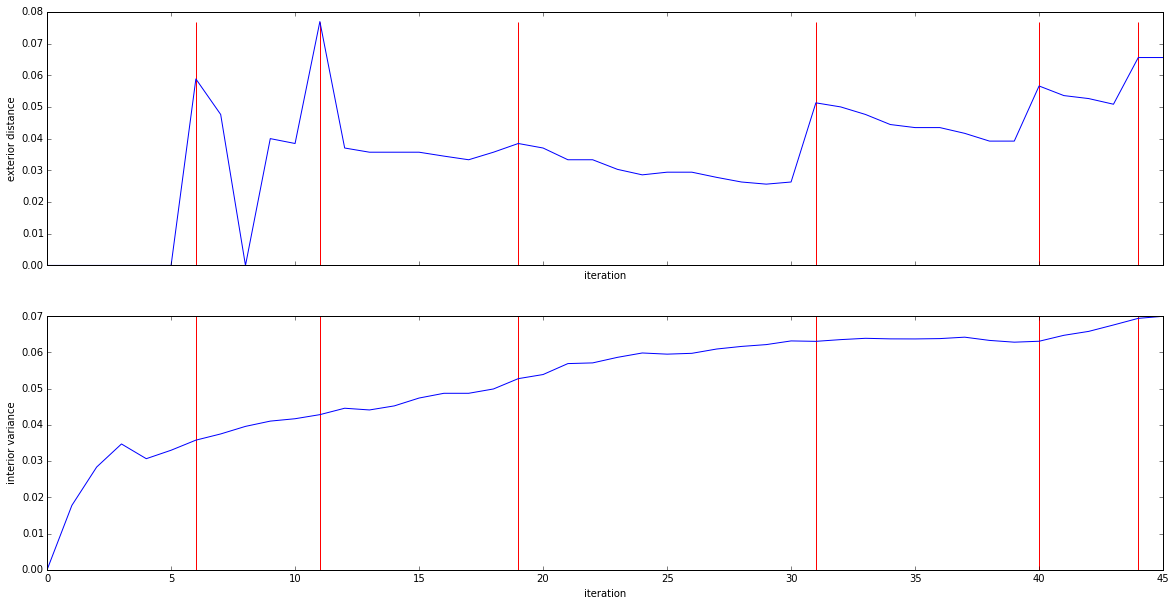

In [22]:
fig, axes = plt.subplots(2,1,squeeze=True, sharex=True, figsize=(20,10))

scores_to_plot = score_tuples[:,1]
axes[0].plot(scores_to_plot);
for p in peaks_sorted2:
    axes[0].vlines(p, ymin=scores_to_plot.min(), ymax=scores_to_plot.max(), colors='r');
axes[0].set_xlabel('iteration');
axes[0].set_ylabel('exterior distance');

scores_to_plot = score_tuples[:,3]
axes[1].plot(scores_to_plot);
for p in peaks_sorted2:
    axes[1].vlines(p, ymin=scores_to_plot.min(), ymax=scores_to_plot.max(), colors='r');
axes[1].set_xlabel('iteration');
axes[1].set_ylabel('interior variance');

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2261: DecompressionBombWarning: Image size (203470848 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


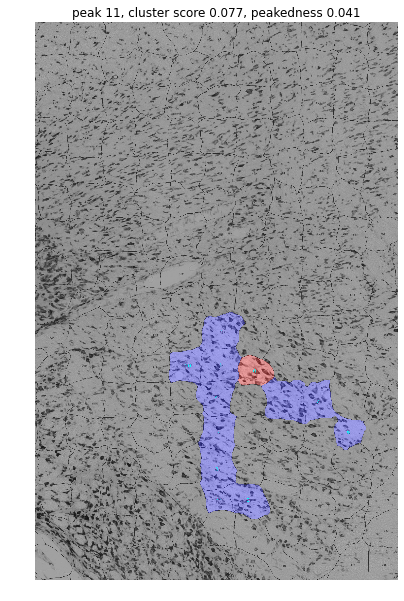

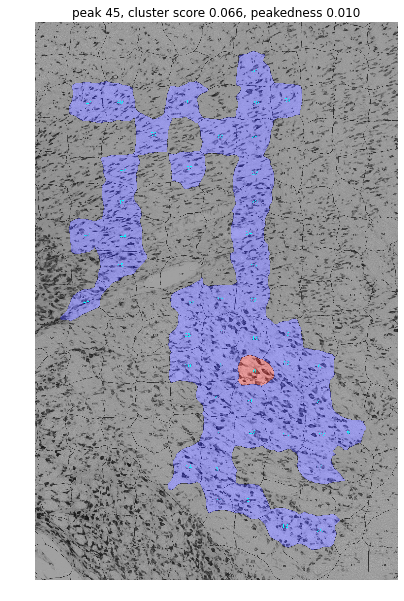

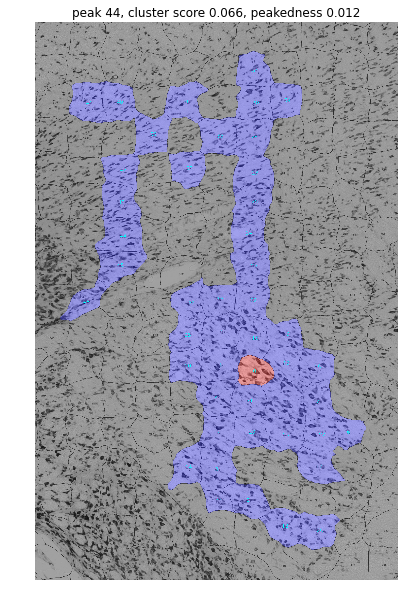

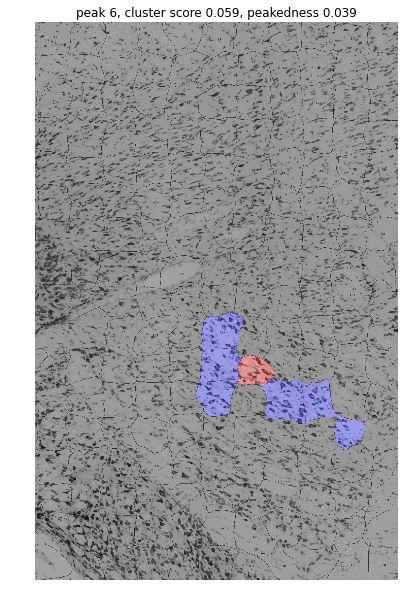

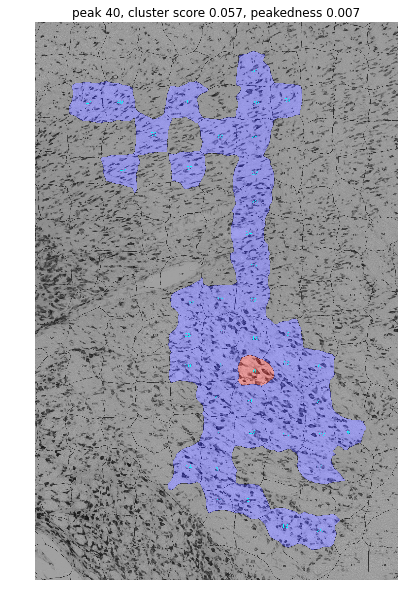

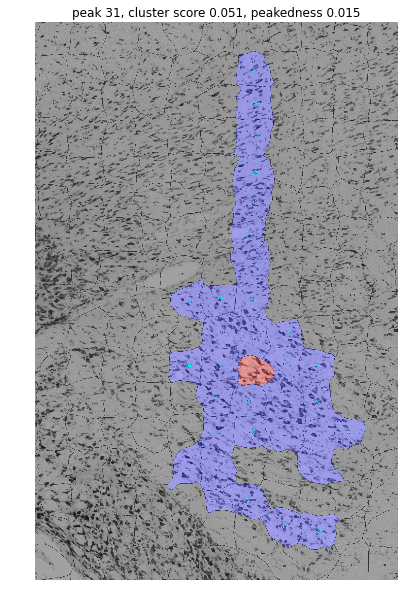

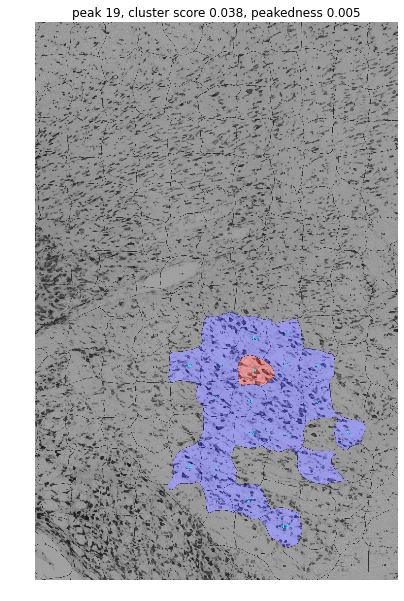

In [19]:
margin = 300

xmin = np.inf
ymin = np.inf
xmax = 0
ymax = 0

for i in peaks_sorted2:
    centroids = dm2.sp_centroids[clusters_allhistory2[i], ::-1]
    xmin = min(xmin, centroids[:,0].min(axis=0))
    xmax = max(xmax, centroids[:,0].max(axis=0))
    ymin = min(ymin, centroids[:,1].min(axis=0))
    ymax = max(ymax, centroids[:,1].max(axis=0))

xmin = int(max(0, xmin - margin))
ymin = int(max(0, ymin - margin))
xmax = int(min(dm2.image_width, xmax + margin))
ymax = int(min(dm2.image_height, ymax + margin))

for peak_ind, p in enumerate(peaks_sorted2):
    viz = dm2.visualize_cluster(clusters_allhistory2[p], highlight_seed=True, seq_text=True,
                               ymin=ymin, xmin=xmin, ymax=ymax, xmax=xmax)
    plt.figure(figsize=(10,10))
    plt.imshow(viz)
    plt.axis('off')
    plt.title('peak %d, cluster score %.3f, peakedness %.3f'%(p, score_tuples[p, 1], peakedness_sorted[peak_ind]))
    plt.show()

In [ ]:
for p in peaks_sorted2:
    find_boundary_dedges_ordered(clusters_allhistory2[p], dm2.de)

In [27]:
clusters_allhistory, score_tuples, peaks_sorted, \
peakedness_sorted, nearest_surrounds, best_candidate_list = grow_cluster4(700, dm.neighbors, dm.neighbors_long, 
                                                                          dm.texton_hists, dm.n_superpixels,
                                                                          verbose=False, all_history=True, 
                                                                          coherence_limit=0.07,
                                                                          num_sp_percentage_limit=0.05,
                                                                          min_size=1, min_distance=3, thresh=.4)

[[ 1]
 [ 8]
 [20]
 [32]]


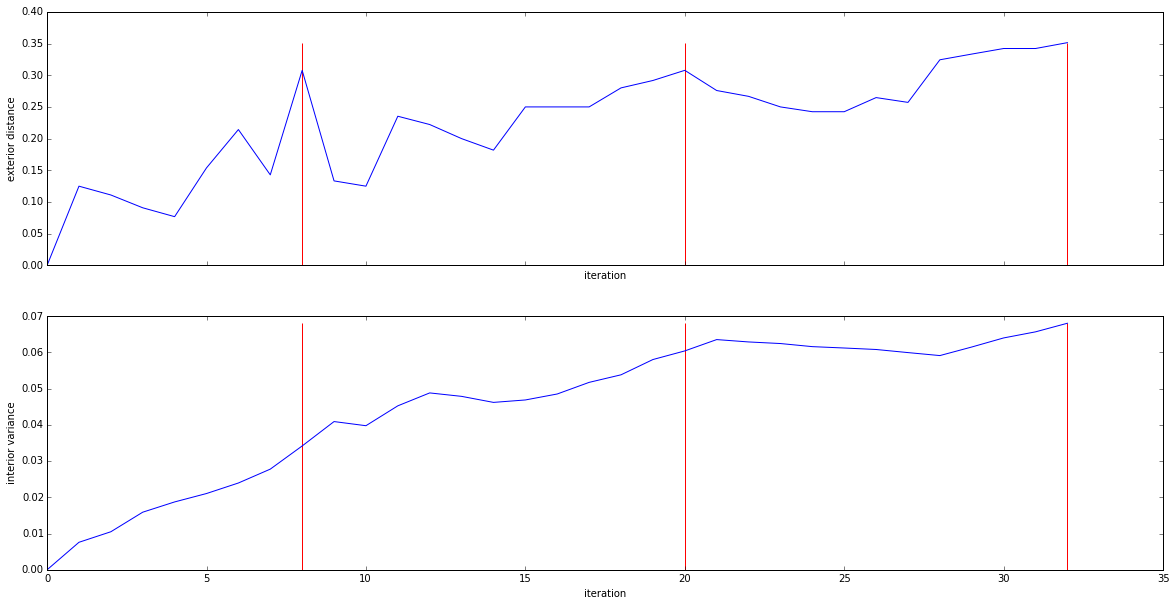

In [28]:
fig, axes = plt.subplots(2,1,squeeze=True, sharex=True, figsize=(20,10))

scores_to_plot = score_tuples[:,1]
axes[0].plot(scores_to_plot);
for p in peaks_sorted:
    axes[0].vlines(p, ymin=scores_to_plot.min(), ymax=scores_to_plot.max(), colors='r');
axes[0].set_xlabel('iteration');
axes[0].set_ylabel('exterior distance');

scores_to_plot = score_tuples[:,3]
axes[1].plot(scores_to_plot);
for p in peaks_sorted:
    axes[1].vlines(p, ymin=scores_to_plot.min(), ymax=scores_to_plot.max(), colors='r');
axes[1].set_xlabel('iteration');
axes[1].set_ylabel('interior variance');

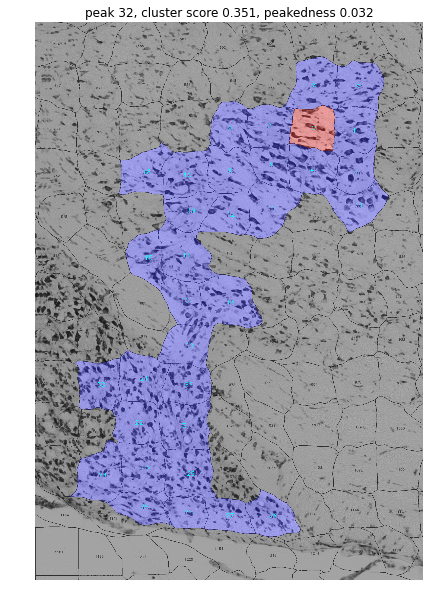

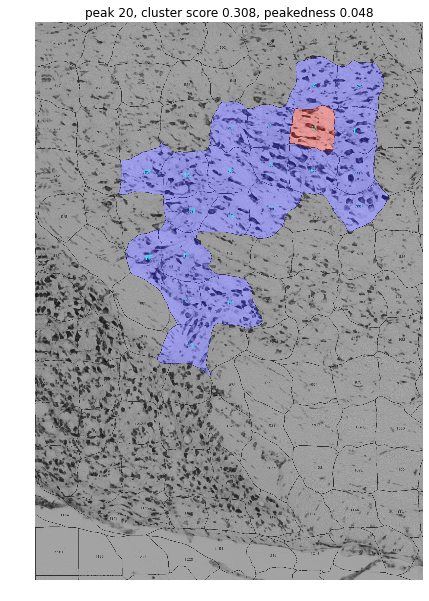

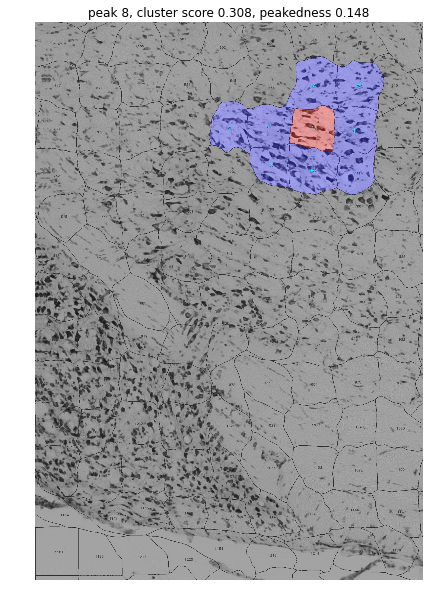

In [29]:
margin = 300

xmin = np.inf
ymin = np.inf
xmax = 0
ymax = 0

for i in peaks_sorted:
    centroids = dm.sp_centroids[clusters_allhistory[i], ::-1]
    xmin = min(xmin, centroids[:,0].min(axis=0))
    xmax = max(xmax, centroids[:,0].max(axis=0))
    ymin = min(ymin, centroids[:,1].min(axis=0))
    ymax = max(ymax, centroids[:,1].max(axis=0))

xmin = int(max(0, xmin - margin))
ymin = int(max(0, ymin - margin))
xmax = int(min(dm.image_width, xmax + margin))
ymax = int(min(dm.image_height, ymax + margin))

for peak_ind, p in enumerate(peaks_sorted):
    viz = dm.visualize_cluster(clusters_allhistory[p], highlight_seed=True, seq_text=True,
                               ymin=ymin, xmin=xmin, ymax=ymax, xmax=xmax)
    plt.figure(figsize=(10,10))
    plt.imshow(viz)
    plt.axis('off')
    plt.title('peak %d, cluster score %.3f, peakedness %.3f'%(p, score_tuples[p, 1], peakedness_sorted[peak_ind]))
    plt.show()

In [24]:
def order_nodes(sps, neighbor_graph, verbose=False):

    subg = neighbor_graph.subgraph(sps)
    d_suc = dfs_successors(subg)
    
    x = [(a,b) for a,b in d_suc.iteritems() if len(b) == 2]
    
    if verbose:
        print 'root, two_leaves', x
    
    if len(x) == 0:
        trav = list(dfs_postorder_nodes(subg))
    else:
        if verbose:
            print 'd_succ'
            for it in d_suc.iteritems():
                print it
        
        root, two_leaves = x[0]

        left_branch = []
        right_branch = []

        c = two_leaves[0]
        left_branch.append(c)
        while c in d_suc:
            c = d_suc[c][0]
            left_branch.append(c)

        c = two_leaves[1]
        right_branch.append(c)
        while c in d_suc:
            c = d_suc[c][0]
            right_branch.append(c)

        trav = left_branch[::-1] + [root] + right_branch
        
        if verbose:
            print 'left_branch', left_branch
            print 'right_branch', right_branch
        
    return trav


def find_boundary_dedges_ordered(cluster, neighbors, edge_coords, 
                                 dedge_neighbor_graph, verbose=False):

    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster])
    surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])
#     surrounds_ordered = order_nodes(surrounds, linking_neighbor_graph)
    
#     frontiers = (set.union(*[neighbors[c] for c in surrounds]) | set()) & set(cluster)
    
    non_border_dedges = [(s, int_sp) for s in surrounds for int_sp in set.intersection(set(cluster), neighbors[s]) 
                         if int_sp != -1 and s != -1]
    border_dedges = [(-1,f) for f in cluster if -1 in neighbors[f]] if -1 in surrounds else []

    dedges_cluster = non_border_dedges + border_dedges
    dedges_cluster_long = [dedge for dedge in dedges_cluster if len(edge_coords[frozenset(dedge)]) > 10]

    if verbose:
        print 'surrounds', surrounds
        print 'non_border_dedges', non_border_dedges
        print 'border_dedges', border_dedges
        print 'dedges_cluster_long', dedges_cluster_long

    dedges_cluster_long_sorted = order_nodes(dedges_cluster_long, dedge_neighbor_graph, verbose=verbose)    
    
    missing = set(dedges_cluster_long) - set(dedges_cluster_long_sorted)
    assert len(missing) == 0, missing
    
    return dedges_cluster_long_sorted

In [179]:
def convert_cluster_to_descriptor(cluster, neighbors, dedge_neighbor_graph, 
                                  texton_hists, edge_coords):

    dedge_set = find_boundary_dedges_ordered(cluster, neighbors, edge_coords, dedge_neighbor_graph)
    
    interior_texture = texton_hists[list(cluster)].mean(axis=0)

    surrounds = [e[0] for e in dedge_set]
    exterior_textures = np.array([texton_hists[s] if s!=-1 else np.nan * np.ones((texton_hists.shape[1],)) 
                                  for s in surrounds])

    points = np.array([edge_coords[frozenset(e)].mean(axis=0) for e in dedge_set])
    center = points.mean(axis=0)

    area = dm.
    
    return (dedge_set, interior_texture, exterior_textures, points, center, area)

In [66]:
peaks_sorted

array([32, 20,  8])

In [67]:
peaks_sorted2

array([11, 45, 44,  6, 40, 31, 19])

In [169]:
ds = []
for p in peaks_sorted:
    d = convert_cluster_to_descriptor(clusters_allhistory[p], dm.neighbors, dm.dedge_neighbor_graph, 
                                  dm.texton_hists, dm.edge_coords)
    ds.append(d)

In [170]:
ds2 = []
for p in peaks_sorted2:
    d2 = convert_cluster_to_descriptor(clusters_allhistory2[p], dm2.neighbors, dm2.dedge_neighbor_graph, 
                                  dm2.texton_hists, dm2.edge_coords)
    ds2.append(d2)

In [64]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/home/yuncong/project/cython-munkres-wrapper/build/lib.linux-x86_64-2.7')
from munkres import munkres

from scipy.spatial.distance import cdist, pdist, squareform

In [108]:
viz = imread('/home/yuncong/Brain/notebooks/tmp.jpg')

In [111]:
viz = dm.visualize_edge_sets([ds[1][0]], bg='segmentationWithText')
display(viz)

In [114]:
viz = dm2.visualize_edge_sets([ds2[-1][0]], bg='segmentationWithText')
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [152]:
# d, D_int, D_ext, D_shape, D_loc 
print boundary_distance(ds[1], ds2[-1], loc_thresh=1500, verbose=True)

D_loc computed
D_interior computed
D_shape computed


best_match [[ 2 22]
 [ 4 24]
 [ 5 26]
 [ 6 25]
 [13 15]
 [15 11]
 [16 10]
 [18 17]
 [19 18]
 [22  7]
 [23  4]
 [24  3]
 [25 19]
 [27  2]
 [28  1]
 [33 41]
 [34 40]
 [41 36]
 [43 35]
 [44 34]
 [45 29]
 [ 0 27]
 [ 1 28]
 [ 3 16]
 [11 13]
 [12 14]
 [14 12]
 [17  9]
 [21  8]
 [29  0]
 [32 42]
 [35 39]
 [37 38]
 [39 37]]
best_sample [array([43, 30]), array([ 5, 26]), array([15, 16])]
best_score 139.579785992
exterior 2 22 0.0352662350781
exterior 4 24 0.134561372226
exterior 5 26 0.260975284292
exterior 6 25 0.127609757048
exterior 13 15 0.544720990782
exterior 15 11 0.103161285729
exterior 16 10 0.165563620632
exterior 18 17 0.0652556180466
exterior 19 18 0.0652556180466
exterior 22 7 0.342315654505
exterior 23 4 0.147028321992
exterior 24 3 0.0781435081885
exterior 25 19 0.0383530520533
exterior 27 2 0.230506743863
exterior 28 1 0.383686912273
exterior 33 41 0.271137894451
exterior 34 40 0.249715700785
exterior 41 36 0.0379873362472
exterior 43 35 0.262368239744
exterior 44 34 0.011393802

In [153]:
print boundary_distance(ds[1], ds2[0], loc_thresh=1500, verbose=True)

D_loc computed
D_interior computed
D_shape computed


best_match [[ 1 21]
 [ 2 20]
 [ 7 12]
 [ 9 10]
 [11  9]
 [12 13]
 [13 14]
 [15  5]
 [16  4]
 [17  3]
 [18  2]
 [20  1]
 [21  0]
 [22 42]
 [24 41]
 [25 40]
 [26 34]
 [28 38]
 [44 28]
 [46 30]
 [ 0 22]
 [ 3 15]
 [ 8 11]
 [10  8]
 [14  6]
 [19 18]
 [27 36]
 [29 37]
 [43 27]
 [45 29]]
best_sample [array([19,  3]), array([45, 23]), array([ 6, 30])]
best_score 133.450715981
exterior 1 21 0.0632154599295
exterior 2 20 0.20014684111
exterior 7 12 0.320256951999
exterior 9 10 0.877038206961
exterior 11 9 0.078891958339
exterior 12 13 0.0909632826992
exterior 13 14 0.825241112501
exterior 15 5 0.514214649792
exterior 16 4 0.0797606666382
exterior 17 3 0.0340808990538
exterior 18 2 0.125163908613
exterior 20 1 0.125163908613
exterior 21 0 0.125163908613
exterior 22 42 0.175983078073
exterior 24 41 0.0946572067388
exterior 25 40 0.0946572067388
exterior 26 34 0.262557178369
exterior 28 38 0.6719085069
exterior 44 28 0.0113938028382
exterior 46 30 0.202570010917
exterior 0 22 0.312289075195
exterio

In [180]:
D = np.array([[boundary_distance(d, d2, loc_thresh=1500, verbose=False)[3] for d2 in ds2] for d in ds])

D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_loc computed
D_loc computed
D_interior computed
D_shape computed
D_loc computed
D_loc computed
D_loc computed
D_interior computed
D_shape computed


In [181]:
np.unravel_index(np.argmin(D), D.shape)

(0, 1)

In [176]:
print peaks_sorted[0], peaks_sorted2[6]

32 19


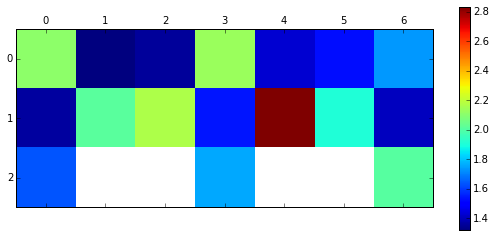

In [184]:
plt.matshow(D);
plt.colorbar();

In [132]:
def rigid_transform_from_pairs(X,Y):
    '''
    X, Y are n-by-2 matrices
    '''
    
    Xcentroid = X.mean(axis=0)
    Ycentroid = Y.mean(axis=0)
    
    Xcentered = X - Xcentroid
    Ycentered = Y - Ycentroid
    
    U, S, V = np.linalg.svd(np.dot(Xcentered.T, Ycentered))
    M = [[1, 0], [0, np.linalg.det(np.dot(V, U.T))]]
    R = np.dot(V, np.dot(M, U.T))
    angle = np.arctan2(R[1,0], R[0,0])
    t = Ycentroid.T - np.dot(R, Xcentroid.T)
    
    T = np.eye(3)
    T[:2, :2] = R
    T[:2, 2] = t
   
    return T, angle

def rigid_transform_to(pts1, T):
    pts1_trans = np.dot(T, np.column_stack([pts1, np.ones((pts1.shape[0],))]).T).T
    pts1_trans = pts1_trans[:,:2]/pts1_trans[:,-1][:,np.newaxis]
    return pts1_trans


def euclidean_dists_angles(points):
    """Returns symmetric pairwise ``dists`` and ``angles`` arrays."""
    
    n = len(points)
    dists = squareform(pdist(points, 'euclidean'))

    xd = -np.subtract.outer(points[:,0], points[:,0])
    yd = -np.subtract.outer(points[:,1], points[:,1])
    angles = np.arctan2(yd,xd)

    closest_neighbor = dists.argsort(axis=1)[:,1]
    tangent_vectors = points[closest_neighbor] - points
    tangent_angles = np.arctan2(tangent_vectors[:,1], tangent_vectors[:,0])

    angles = angles - tangent_angles[:, np.newaxis]
    angles = angles%(2*np.pi)
    angles[angles > np.pi] = angles[angles > np.pi] - 2*np.pi

    return dists, angles

def compute_r_theta_bins(n_radial_bins=5, n_polar_bins=12, dist_limit=1.):
    """
    Generate radius-theta bins for the shape context histogram.
    
    Args:
        n_radial_bins (int): number of radial bins
        n_polar_bins (int): number of polar bins
        dist_limit (float): between 0 and 1

    Returns:
        (float array, float array): (r_array, theta_array)

    """
        
    base = 10.    
    r_array = dist_limit * (np.logspace(0, 1, n_radial_bins + 1, base=10) - 1)[1:] / (base-1)
    theta_array = np.linspace(-np.pi, np.pi, n_polar_bins + 1)[1:]
    
    return r_array, theta_array

def compute_shape_context_descriptors(pts, n_radial_bins=5, n_polar_bins=12, 
                                      dist_limit=1., density=True):

    dists, angles = euclidean_dists_angles(pts)
    n_points = dists.shape[0]
    
    r_array, theta_array = compute_r_theta_bins(n_radial_bins, n_polar_bins, dist_limit)
    
    descriptors_mat = np.zeros((n_points, n_radial_bins, n_polar_bins), dtype=np.int)

    dists = dists / dists.max()

    for i in range(n_points):
        for j in range(i + 1, n_points):
            
            if dists[i, j] >= r_array[-1]:
                continue

            r_idx = np.searchsorted(r_array, dists[i, j])
            theta_idx = np.searchsorted(theta_array, angles[i, j])

            descriptors_mat[i, r_idx, theta_idx] += 1

            theta_idx = np.searchsorted(theta_array, angles[j, i])
            descriptors_mat[j, r_idx, theta_idx] += 1

    descriptors = descriptors_mat.reshape(descriptors_mat.shape[0], -1).astype(np.float)

    if density:
        descriptors = descriptors/np.sum(descriptors, axis=1)[:,None]
    
    return descriptors

In [140]:
from scipy.misc import comb
import random

def ransac_compute_rigid_transform(Dm, pts1, pts2, confidence_thresh=.01, ransac_iters=20, sample_size=5,
                                  matching_iter=10, n_neighbors=10, verbose=False):

#     q = time.time()
    
    high_confidence_thresh = np.sort(Dm.flat)[int(confidence_thresh * np.size(Dm))]
#     print 'high_confidence_thresh', high_confidence_thresh
    
    N1 = len(pts1)
    N2 = len(pts2)
    
    rs, cs = np.where(Dm < high_confidence_thresh)
    high_confidence_pairs = np.c_[rs,cs]
    
    if len(high_confidence_pairs) == 0:
        return None, [], None, np.inf
    
    if verbose:
        print 'high_confidence_pairs', high_confidence_pairs
    
#     from itertools import combinations
#     possible_samples = list(combinations(high_confidence_pairs, sample_size))
#     random.shuffle(possible_samples)
    
#     n_possible_samples = len([t for t in combinations(high_confidence_pairs, sample_size) 
#                         if allunique([tt[0] for tt in t]) and allunique([tt[1] for tt in t])])
#     print 'n_possible_samples', len(possible_samples)
#     random.shuffle(possible_samples)

#     print 'comb', time.time() - q

#     return
    
    p1s = np.sort(list(set(rs)))
    p2s = np.sort(list(set(cs)))
    n1 = len(p1s)
    n2 = len(p2s)
    
    if n1 < sample_size or n2 < sample_size:
        return None, [], None, np.inf
    
    offsets = []
    scores = []
    matches_list = []
    samples_list = []
    
    sample_counter = 0
    n_possible_samples = int(comb(len(high_confidence_pairs), sample_size, exact=False))

    if verbose:
        sys.stderr.write('n_possible_samples = %d\n' % n_possible_samples)
    
#     n_possible_samples = len(possible_samples)
    for ri in range(min(ransac_iters, n_possible_samples)):
#         sys.stderr.write('ri = %d\n' % ri)

        samples = []
        
        for tt in range(100):
#             sys.stderr.write('tt = %d\n' % tt)

#             s = possible_samples[sample_counter]
            s = random.sample(high_confidence_pairs, sample_size)
            sample_counter += 1
            w1, w2 = zip(*s)
            if len(set(w1)) == len(w1) and len(set(w2)) == len(w2):
                samples = s
                break
                
        if len(samples) == 0:
            continue
            
#         samples = np.array(possible_samples[ri])

        if verbose:
            sys.stderr.write('samples = %d\n' % ri)
#             print '\nsamples', ri, samples
        
        X = pts1[[s[0] for s in samples]]
        Y = pts2[[s[1] for s in samples]]
                
        # generate transform hypothesis
        T, angle = rigid_transform_from_pairs(X, Y)
        if np.abs(angle) > np.pi/4:
            if verbose:
                print 'angle too wide', np.rad2deg(angle)
            continue
        
        # apply transform hypothesis
        pts1_trans = rigid_transform_to(pts1, T)
        
        # iterative closest point association
        matches = None
        matches_prev = None
        
        for mi in range(matching_iter):
  
            # given transform, find matching

#             t1 = time.time()
        
#             b = time.time()
    
            Dh = cdist(pts1_trans, pts2, metric='euclidean')
            Dargmin1 = Dh.argsort(axis=1)
            Dargmin0 = Dh.argsort(axis=0)
#             print 'cdist', time.time() - b
        
#             b = time.time()
            
            D2 = Dh.copy()
            D2[np.arange(N1)[:,np.newaxis], Dargmin1[:,n_neighbors:]] = 999
            D2[Dargmin0[n_neighbors:,:], np.arange(N2)[np.newaxis,:]] = 999
            D_hc_pairs = D2[p1s[:,np.newaxis], p2s]
                
#             D_hc_pairs = 9999 * np.ones((n1, n2))
#             for i,j in high_confidence_pairs:
#                 if j in Dargmin1[i,:10] and i in Dargmin0[:10,j]:
#                     ii = p1s.index(i)
#                     jj = p2s.index(j)
#                     D_hc_pairs[ii, jj] = Dh[i,j]

#             print 'D_hc_pairs', time.time() - b

            if matches is not None:
                matches_prev = matches
        
#             b = time.time()
            matches_hc_pairs = np.array(zip(*np.nonzero(munkres(D_hc_pairs))))
#             print 'munkres', time.time() - b, mi
            
#             b = time.time()

#                 print [(p1s[ii], p2s[jj]) for (ii,jj) in matches_hc_pairs]
            matches = np.array([(p1s[ii], p2s[jj]) for (ii,jj) in matches_hc_pairs
                                if D_hc_pairs[ii, jj] != 999])
            # some 9999 edges will be included, the "if" above removes them
#             print 'matches', time.time() - b
        
            expanded_matches = []
            matches1 = set([i for i,j in matches])
            matches2 = set([j for i,j in matches])
            rem1 = set(range(N1)) - matches1
            rem2 = set(range(N2)) - matches2
            add1 = set([])
            add2 = set([])
            for i in rem1:
                for j in rem2:
                    if j in Dargmin1[i,:3] and i in Dargmin0[:3,j] and i not in add1 and j not in add2:
                        add1.add(i)
                        add2.add(j)
                        expanded_matches.append((i,j))

            if len(expanded_matches) > 0 and len(matches) > 0 :
                matches = np.vstack([matches, np.array(expanded_matches)])
    
            if verbose:
#                 print 'considered pairs', w
#                 print 'matches', [(i,j) for i,j in matches
                q1, q2 = np.where(D_hc_pairs < 999)
                w = zip(*[p1s[q1], p2s[q2]])
                print 'matches', len(matches), '/', 'considered pairs', len(w), '/', 'all hc pairs', len(high_confidence_pairs)

#             t2 = time.time()
            
            if len(matches) < 3:
                s = np.inf
                break
            else:
                xs1 = pts1_trans[matches[:,0], 0]
                x_coverage1 = float(xs1.max() - xs1.min()) / (pts1_trans[:,0].max() - pts1_trans[:,0].min())
                ys1 = pts1_trans[matches[:,0], 1]
                y_coverage1 = float(ys1.max() - ys1.min()) / (pts1_trans[:,1].max() - pts1_trans[:,1].min())
                
                xs2 = pts2[matches[:,1], 0]
                x_coverage2 = float(xs2.max() - xs2.min())/ (pts2[:,0].max() - pts2[:,0].min())
                ys2 = pts2[matches[:,1], 1]
                y_coverage2 = float(ys2.max() - ys2.min())/ (pts2[:,1].max() - pts2[:,1].min())
                
                coverage = .5 * x_coverage1 * y_coverage1 + .5 * x_coverage2 * y_coverage2
                
                s = Dh[matches[:,0], matches[:,1]].mean() / coverage**2    
#             s = .5 * Dm[Dh.argmin(axis=0), np.arange(len(pts2))].mean() + .5 * Dm[np.arange(len(pts1)), Dh.argmin(axis=1)].mean()            
#             s = np.mean([np.mean(Dh.min(axis=0)), np.mean(Dh.min(axis=1))])
    
            X = pts1[matches[:,0]]
            Y = pts2[matches[:,1]]

            T, angle = rigid_transform_from_pairs(X, Y)
            if np.abs(angle) > np.pi/4:
                break

            pts1_trans = rigid_transform_to(pts1, T)
            
            if matches_prev is not None and all([(i,j) in matches_prev for i,j in matches]):
                break
                
#             print 'coverage and remaining', mi, time.time() - t2
        
#             print mi, time.time() - t1
                
#         Dh = cdist(pts1_trans, pts2, metric='euclidean')
#         Dargmin1 = Dh.argsort(axis=1)
#         Dargmin0 = Dh.argsort(axis=0)
        
#         expanded_matches = []
#         matches1 = set([i for i,j in matches])
#         matches2 = set([j for i,j in matches])
#         rem1 = set(range(N1)) - matches1
#         rem2 = set(range(N2)) - matches2
#         add1 = set([])
#         add2 = set([])
#         for i in rem1:
#             for j in rem2:
#                 if j in Dargmin1[i,:3] and i in Dargmin0[:3,j] and i not in add1 and j not in add2:
#                     add1.add(i)
#                     add2.add(j)
#                     expanded_matches.append((i,j))
                    
#         if len(expanded_matches) > 0 and len(matches) > 0 :
#             matches = np.vstack([matches, np.array(expanded_matches)])
        
#         print matches
                            
        samples_list.append(samples)
        offsets.append(T)
        matches_list.append(matches)
        scores.append(s)
    
        if verbose:
            print matches
            print s
            plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), 
                       center1=False, center2=False,
                       text=True, matchings=matches)
            
    if len(scores) > 0:
        best_i = np.argmin(scores)

        best_score = scores[best_i]
        best_T = offsets[best_i]
        best_sample = samples_list[best_i]
        best_matches = matches_list[best_i]    
    
        return best_T, best_matches, best_sample, best_score
    else:
        return None, [], None, np.inf

In [129]:
def plot_two_pointsets(pts1, pts2, center1=True, center2=True, text=True, 
                       matchings=None, show_sc1=None, show_sc2=None, 
                       r_array=None, n_angles=None):
    '''
    show_sc1 is the point index on which to draw shape context polar histogram boundaries
    '''
    
    pts1 = pts1*np.array([1,-1])
    pts2 = pts2*np.array([1,-1])

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
#     ax.scatter(pts1[:,0], pts1[:,1], c='r', label='PointSet 1', s=40)
#     ax.scatter(pts2[:,0], pts2[:,1], c='g', label='PointSet 2', s=40)
    ax.scatter(pts1[:,0], pts1[:,1], c='r', label='PointSet 1', s=5)
    ax.scatter(pts2[:,0], pts2[:,1], c='g', label='PointSet 2', s=5)

    if center1:
        center1 = pts1.mean(axis=0)
        ax.scatter(center1[0], center1[1], c='b')

    if center2:
        center2 = pts2.mean(axis=0)
        ax.scatter(center2[0], center2[1], c='b')

    if text:
        for i, (y,x) in enumerate(pts1):
            ax.text(y, x, str(i), color='r')

        for i, (y,x) in enumerate(pts2):
            ax.text(y, x, str(i), color='g')
    
    if matchings is not None:
        for i,j in matchings:
            ln = plt.Line2D(np.r_[pts1[i,0], pts2[j,0]], np.r_[pts1[i,1], pts2[j,1]], c='k')
            fig.gca().add_artist(ln)
    
    if show_sc1 is not None:
        assert r_array is not None and n_angles is not None
        dists_max1 = pdist(pts1).max() 
        scales1 = dists_max1 * r_array
        
        for s in scales1:
            circle = plt.Circle(pts1[show_sc1], s, color='k', fill=False)
            fig.gca().add_artist(circle)

        angs = np.linspace(np.pi, -np.pi, n_angles+1)[:-1]
        na = len(angs)
        for ai, a in enumerate(angs):
            ln = plt.Line2D(np.r_[pts1[show_sc1,0], pts1[show_sc1,0]+scales1[-1]*np.cos(a)], 
                            np.r_[pts1[show_sc1,1], pts1[show_sc1,1]+scales1[-1]*np.sin(a)], c='k')
            fig.gca().add_artist(ln)
            fig.gca().text(.5*(pts1[show_sc1,0]+scales1[0]*np.cos(a))+.5*(pts1[show_sc1,0]+scales1[0]*np.cos(angs[(ai+1)%na])), 
                           .5*(pts1[show_sc1,1]+scales1[0]*np.sin(a))+.5*(pts1[show_sc1,1]+scales1[0]*np.sin(angs[(ai+1)%na])), 
                           str(ai),
                           horizontalalignment='center',
                           verticalalignment='center')
            
    if show_sc2 is not None:
        assert r_array is not None and n_angles is not None
        dists_max2 = pdist(pts2).max()
        scales2 = dists_max2 * r_array

        for s in scales2:
            circle = plt.Circle(pts2[show_sc2], s, color='k', fill=False)
            fig.gca().add_artist(circle)
            
        angs = np.linspace(np.pi, -np.pi, n_angles+1)[:-1]
        na = len(angs)
        for ai, a in enumerate(angs):
            ln = plt.Line2D(np.r_[pts2[show_sc2,0], pts2[show_sc2,0]+scales2[-1]*np.cos(a)], 
                            np.r_[pts2[show_sc2,1], pts2[show_sc2,1]+scales2[-1]*np.sin(a)], c='k')
            fig.gca().add_artist(ln)
            fig.gca().text(.5*(pts2[show_sc2,0]+scales2[0]*np.cos(a))+.5*(pts2[show_sc2,0]+scales2[0]*np.cos(angs[(ai+1)%na])), 
               .5*(pts2[show_sc2,1]+scales2[0]*np.sin(a))+.5*(pts2[show_sc2,1]+scales2[0]*np.sin(angs[(ai+1)%na])), 
               str(ai),
               horizontalalignment='center',
               verticalalignment='center')


            
#     ax.legend()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

In [130]:
def shape_context_score(pts1, pts2, descriptor1=None, descriptor2=None, verbose=False):

    if descriptor1 is None:
        descriptor1 = compute_shape_context_descriptors(pts1, dist_limit=.8)
    
    if descriptor2 is None:
        descriptor2 = compute_shape_context_descriptors(pts2, dist_limit=.8)
        
    descriptor_dists = cdist(descriptor1, descriptor2, metric='euclidean')
        
#     b = time.time()

    T, best_match, best_sample, best_score = ransac_compute_rigid_transform(descriptor_dists, pts1, pts2, 
                                                                            ransac_iters=50, confidence_thresh=0.03, 
                                                                            sample_size=3, matching_iter=10,
                                                                           n_neighbors=3)
#     print 'ransac_compute_rigid_transform', time.time() - b

    
    if T is None and len(best_match)==0:
        return np.inf, []
    
    if verbose:
        print 'best_match', best_match
        print 'best_sample', best_sample
        print 'best_score', best_score

    return best_score, best_match

In [178]:
def boundary_distance(b1, b2, sc1=None, sc2=None, loc_thresh=1500, verbose=False):
    '''
    Compute the distance between two boundaries.
    Each tuple consists of (edgeSet, interior_texture, exterior_textures, points, center)
    
    Parameters
    ----------
    b1 : tuple
    b2 : tuple
    sc1 : #points-by-32 array
        pre-computed shape context descriptor
    sc2 : #points-by-32 array
        pre-computed shape context descriptor
    '''
    
    _, interior_texture1, exterior_textures1, points1, center1, cl1 = b1
    _, interior_texture2, exterior_textures2, points2, center2, cl2 = b2
    if sc1 is not None:
        assert len(sc1) == points1.shape[0], 'number mismatch %d %d'%(len(sc1), points1.shape[0])
    
    if sc2 is not None:
        assert len(sc2) == points2.shape[0], 'number mismatch %d %d'%(len(sc2), points2.shape[0])

    # compute location difference
    d_loc = np.linalg.norm(center1 - center2)
    D_loc = np.maximum(0, d_loc - 500)
    
    sys.stderr.write('D_loc computed\n')
#     print 'd_loc', d_loc

    if d_loc > loc_thresh:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    n1 = len(points1)
    n2 = len(points2)
    
    if max(n1,n2) > min(n1,n2) * 3:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    # compute interior texture difference
    D_int = chi2(interior_texture1, interior_texture2)
#     D_ext = hausdorff_histograms(exterior_textures1, exterior_textures2, metric=chi2)

    sys.stderr.write('D_interior computed\n')

    # compute shape difference, exterior texture difference
    D_shape, matches = shape_context_score(points1, points2, descriptor1=sc1, descriptor2=sc2, verbose=verbose)
#         D_ext = np.mean([chi2(exterior_textures1[i], exterior_textures2[j]) for i, j in matches])
    
    sys.stderr.write('D_shape computed\n')
    
    bg_match = 0

    if len(matches) == 0:
        D_ext = np.inf
    else:
        ddd = []
        for i, j in matches:
            # -1 vs -1
            if np.isnan(exterior_textures1[i]).all() and np.isnan(exterior_textures2[j]).all():
                s = 0
                bg_match += 1
                ddd.append(s)
            # non -1 vs non -1
            elif not np.isnan(exterior_textures1[i]).all() and not np.isnan(exterior_textures2[j]).all():
                s = chi2(exterior_textures1[i], exterior_textures2[j])
                if verbose:
                    print 'exterior', i,j,s
                ddd.append(s)
            # -1 vs non -1
            else:
                ddd.append(2.)

        if len(ddd) == 0:
            D_ext = np.inf
        elif len(ddd) == bg_match:
            D_ext = 2.
        else:
            D_ext = np.mean(ddd)
    
    D_shape = D_shape * .01

    D_area = len(cl1) - len(cl2)
    
    # weighted average of four terms
    d = D_int + D_ext + D_shape + 0 * D_loc + .5 * D_area
    
    return d, D_int, D_ext, D_shape, D_loc, D_area

In [ ]:
# neighbor_hist_dists = [zip(list(neighbors[s]), chi2s(texton_hists[s], texton_hists[list(neighbors[s])])) for s in range(n_superpixels)]

In [ ]:
# edge_dists = {}
# for e in edge_coords.iterkeys():
#     i, j = e
#     edge_dists[e] = chi2(texton_hists[i], texton_hists[j])

In [ ]:
# plt.hist(edge_dists.values(), bins=100);

In [ ]:
# segmentation_viz = dm.load_pipeline_result('segmentationWithText')

In [ ]:
# import cv2
# viz = img_as_ubyte(segmentation_viz[dm.ymin:dm.ymax+1, dm.xmin:dm.xmax+1])
# for e, coords in edge_coords.iteritems():
#     i, j = e
#     if len(coords) > 50 and i != -1 and j != -1:
#         cv2.line(viz, 
#                  (sp_centroids[i,0].astype(np.int)-dm.xmin, sp_centroids[i,1].astype(np.int)-dm.ymin), 
#                  (sp_centroids[j,0].astype(np.int)-dm.xmin, sp_centroids[j,1].astype(np.int)-dm.ymin), 
#                  (255,0,0), int(30*edge_dists[e]))

In [ ]:
# display(viz)

In [ ]:
def compute_nearest_surround(cluster):
    cluster_list = list(cluster)
    cluster_avg = texton_hists[cluster_list].mean(axis=0)    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    surrounds_list = list(surrounds)
    ds = np.squeeze(chi2s([cluster_avg], texton_hists[surrounds_list]))     
    surround_dist = ds.min()
    return surrounds_list[ds.argmin()]


def compute_cluster_score(cluster, neighbors, texton_hists, verbose=False, thresh=.2):
    
    cluster_list = list(cluster)
    cluster_avg = texton_hists[cluster_list].mean(axis=0)
    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    if len(surrounds) == 0: # single sp on background
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    surrounds_list = list(surrounds)
        
#     ds = np.squeeze(chi2s([cluster_avg], texton_hists[surrounds_list])) 
    ds = np.squeeze(cdist([cluster_avg], texton_hists[surrounds_list], chi2))
#     ds = np.squeeze(cdist([cluster_avg], texton_hists[surrounds_list], kl))
    
#     sur_hists = [texton_hists[list(neighbors[s])].mean(axis=0) for s in surrounds_list]
#     ds = np.squeeze(cdist([cluster_avg], sur_hists, chi2))
    
#     thresh = .2
#     surround_dist = np.count_nonzero(ds > thresh) / float(len(ds)) # hard

    sigma = .05
    surround_dist = np.sum(1./(1+np.exp((thresh - ds)/sigma)))/len(ds); #soft

#     surround_dist = ds.min()
    if verbose:
        print 'min', surrounds_list[ds.argmin()]

#     surds, _ = find_boundary_sps([cluster], neighbors=neighbors, neighbor_graph=neighbor_graph)
    
#     compactness = len(surds[0])**2/float(len(cluster))
#     compactness = .001 * np.maximum(compactness-40,0)**2
    
#     size_prior = .1 * (1-np.exp(-.8*len(cluster)))
    
#     score = surround_dist - compactness + size_prior
    score = surround_dist
    
    if len(cluster) > 1:
        ds = np.squeeze(chi2s([cluster_avg], texton_hists[list(cluster)]))
        var = ds.mean()
#         var = np.sum(ds**2)/len(ds)
    else:
        var = 0
    
    interior_dist = np.nan
    compactness = np.nan
    interior_pval = np.nan
    surround_pval = np.nan
    size_prior = np.nan
    
    return score, surround_dist, var, compactness, surround_pval, interior_pval, size_prior

In [ ]:
from itertools import chain
from skimage.feature import peak_local_max
from scipy.spatial import ConvexHull
from matplotlib.path import Path

def grow_cluster4(seed, verbose=False, all_history=False, coherence_limit=0.005, num_sp_percentage_limit=0.05,
                 min_size=4, min_distance=5, thresh=.2):
    try:
    
        visited = set([])
        curr_cluster = set([])

        candidate_scores = [0]
        candidate_sps = [seed]

        score_tuples = []
        added_sps = []
        n_sps = []
        
        cluster_list = []
        addorder_list = []
        
        iter_ind = 0

        hull_begin = False
        
        nearest_surrounds = []
        toadd_list = []

        while len(candidate_sps) > 0:
            
            if verbose:
                print '\niter', iter_ind

            best_ind = np.argmax(candidate_scores)

            just_added_score = candidate_scores[best_ind]
            sp = candidate_sps[best_ind]

            del candidate_scores[best_ind]
            del candidate_sps[best_ind]

            if sp in curr_cluster:
                continue

            curr_cluster.add(sp)
            added_sps.append(sp)

            extra_sps = []
            
#             sg = neighbor_graph.subgraph(list(set(range(n_superpixels))-curr_cluster))
            sg = neighbor_long_graph.subgraph(list(set(range(n_superpixels))-curr_cluster))
            for c in connected_components(sg):
                if len(c) < 10: # holes
                    extra_sps.append(c)
            extra_sps = list(chain(*extra_sps))
            curr_cluster |= set(extra_sps)
            added_sps += extra_sps
                
#             if not hull_begin:
#                 pts = sp_centroids[list(curr_cluster)]
#                 # if all points are colinear, ConvexHull will fail
#                 try:
#                     hull = ConvexHull(pts, incremental=True)
#                     hull_begin = True
#                 except:
#                     pass

#             if hull_begin:
                
#                 hull.add_points([sp_centroids[sp]])

#                 vertices = hull.points[hull.vertices]
#                 mpath = Path(vertices)
#                 xmin, ymin = vertices.min(axis=0)
#                 xmax, ymax = vertices.max(axis=0)

#                 in_bbox_sps = np.where((sp_centroids[:,0] >= xmin) & (sp_centroids[:,1] >= ymin) & \
#                                 (sp_centroids[:,0] <= xmax) & (sp_centroids[:,1] <= ymax))[0]

#                 extra_sps_to_consider = np.asarray(list(set(in_bbox_sps)))
#                 if verbose:
#                     print '\nextra_sps_to_consider', extra_sps_to_consider
#                 if len(extra_sps_to_consider) > 0:
#                     in_hull = mpath.contains_points(sp_centroids[extra_sps_to_consider])
#                     if np.any(in_hull):
#                         extra_sps = extra_sps_to_consider[in_hull]
#                         hull.add_points(sp_centroids[extra_sps])
#                         curr_cluster |= set(list(extra_sps))
#                         added_sps += extra_sps.tolist()


            tt = compute_cluster_score(curr_cluster, neighbors, texton_hists=texton_hists, verbose=verbose,
                                      thresh=thresh)
    
            nearest_surround = compute_nearest_surround(curr_cluster)
            nearest_surrounds.append(nearest_surround)
            
            tot, exterior, interior, compactness, surround_pval, interior_pval, size_prior = tt
            
            if len(curr_cluster) > 5 and (interior > coherence_limit):
                break
            
            if np.isnan(tot):
                return [seed], -np.inf
            score_tuples.append(np.r_[just_added_score, tt])
                    
            n_sps.append(len(curr_cluster))
    
            # just_added_score, curr_total_score, exterior_score, interior_score, compactness_score, surround_pval,
            # interior_pval, size_prior

            if verbose:
                print 'add', sp
                print 'extra', extra_sps
                print 'added_sps', added_sps
                print 'curr_cluster', curr_cluster
                print 'n_sps', n_sps
                print 'tt', tot
                if len(curr_cluster) != len(added_sps):
                    print len(curr_cluster), len(added_sps)
                    raise                

#             visited.add(sp)
            
            cluster_list.append(curr_cluster.copy())
            addorder_list.append(added_sps[:])
            
            
#             if hull_begin:
#             visited |= set(list(extra_sps))
            
#             if hull_begin and len(extra_sps) > 0:
            candidate_sps = (set(candidate_sps) | \
                             (set.union(*[neighbors_long[i] for i in list(extra_sps)+[sp]]) - {-1})) - curr_cluster
#             else:
            
#             candidate_sps = (set(candidate_sps) | (neighbors[sp] - set([-1])) | (visited - curr_cluster)) - curr_cluster                
#             candidate_sps = (set(candidate_sps) | (neighbors[sp] - {-1})) - curr_cluster                

#             if hull_begin and len(extra_sps) > 0:
#                 candidate_sps = (set(candidate_sps) | ((set.union(*[neighbors_long[i] for i in list(extra_sps)]) | neighbors_long[sp]) - set([-1])) | (visited - curr_cluster)) - curr_cluster
#             else:
#                 candidate_sps = (set(candidate_sps) | (neighbors_long[sp] - set([-1])) | (visited - curr_cluster)) - curr_cluster

            candidate_sps = list(candidate_sps)
            
            h_avg = texton_hists[list(curr_cluster)].mean(axis=0)
        
#             candidate_scores = -chi2s([h_avg], texton_hists[candidate_sps])

            candidate_scores = -.5*chi2s([h_avg], texton_hists[candidate_sps])-\
                            .5*chi2s([texton_hists[seed]], texton_hists[candidate_sps])
            
#             candidate_scores = -chi2s([h_avg], texton_hists[candidate_sps])
#                                 -.5*chi2s([texton_hists[seed]], texton_hists[candidate_sps])
#                                 .5*chi2s([texton_hists[[1516,1517]].mean(axis=0)], texton_hists[candidate_sps])+\
#                                 .5*chi2s([texton_hists[[1935,1934]].mean(axis=0)], texton_hists[candidate_sps])
        
#             cand_hists = np.array([texton_hists[list(neighbors[s] - curr_cluster)].mean(axis=0) for s in candidate_sps])
#             candidate_scores = -chi2s([h_avg], cand_hists)
    
#             candidate_scores = -np.squeeze(cdist([h_avg], texton_hists[candidate_sps], kl))
            candidate_scores = candidate_scores.tolist()
#             candidate_scores = [-chi2(h_avg, texton_hists[i]) for i in candidate_sps]

            if verbose:
#                 print 'candidate', candidate_sps
                print 'candidate\n'
    
                for i,j in sorted(zip(candidate_scores, candidate_sps), reverse=True):
                    print i, j
                print 'best', candidate_sps[np.argmax(candidate_scores)]
                
            toadd_list.append(candidate_sps[np.argmax(candidate_scores)])

            if len(curr_cluster) > int(n_superpixels * num_sp_percentage_limit):
                break
                
            iter_ind += 1

        score_tuples = np.array(score_tuples)
        scores = score_tuples[:,1]
        
        peaks_sorted, peakedness_sorted = find_score_peaks(scores, min_size=min_size, min_distance=min_distance)
        
        if all_history:
            return addorder_list, score_tuples, peaks_sorted, peakedness_sorted, nearest_surrounds, toadd_list
        else:
            return [addorder_list[i] for i in peaks_sorted], score_tuples[peaks_sorted, 1]
            
    except:
        print seed
        raise

In [ ]:
def find_score_peaks(scores, min_size = 4, min_distance=10, threshold_rel=.3, peakedness_lim=.001,
                    peakedness_radius=5):
    
    if len(scores) > min_size + 1:
    
        peaks = peak_local_max(scores[min_size:]-scores[min_size:].min(), min_distance=min_distance, 
                                      threshold_rel=threshold_rel, exclude_border=False)
                
        print peaks
        
        if len(peaks) > 0:
            peaks = min_size + peaks.T
            peaks = peaks[0]

            peakedness = np.array([scores[p]-np.mean(np.r_[scores[p-peakedness_radius:p], 
                                                           scores[p+1:p+1+peakedness_radius]]) for p in peaks])

            peaks = peaks[peakedness > peakedness_lim]
            peakedness = peakedness[peakedness > peakedness_lim]

            peaks_sorted = peaks[scores[peaks].argsort()[::-1]]
        else:
            peaks = np.array([np.argmax(scores[min_size:]) + min_size])
            peakedness = np.atleast_1d([scores[p]-np.mean(np.r_[scores[max(0, p-peakedness_radius):p], 
                                                           scores[p+1:min(p+1+peakedness_radius, len(scores))]]) 
                                       for p in peaks])
            peaks = peaks[peakedness > peakedness_lim]
            peakedness = peakedness[peakedness > peakedness_lim]
            peaks_sorted = peaks[scores[peaks].argsort()[::-1]]
    else:
        peaks = np.array([np.argmax(scores)])
        peakedness = np.atleast_1d([scores[p]-np.mean(np.r_[scores[max(0, p-peakedness_radius):p], 
                                                           scores[p+1:min(p+1+peakedness_radius, len(scores))]]) 
                                       for p in peaks])
        peaks_sorted = peaks[scores[peaks].argsort()[::-1]]
    
    peakedness_sorted = np.atleast_2d(peakedness[scores[peaks].argsort()[::-1]])[0]
    
    return peaks_sorted, peakedness_sorted    


In [ ]:
t = time.time()
clusters_allhistory, score_tuples, peaks_sorted, \
peakedness_sorted, nearest_surrounds, best_candidate_list = grow_cluster4(768, all_history=True, verbose=False,
                                                                         min_size=1,
                                                                          min_distance=10,
                                                                         coherence_limit=0.05,
                                                                         thresh=.3)
print time.time() - t

In [ ]:
fig, axes = plt.subplots(2,1,squeeze=True, sharex=True, figsize=(20,10))

scores_to_plot = score_tuples[:,1]
axes[0].plot(scores_to_plot);
for p in peaks_sorted:
    axes[0].vlines(p, ymin=scores_to_plot.min(), ymax=scores_to_plot.max(), colors='r');
axes[0].set_xlabel('iteration');
axes[0].set_ylabel('exterior distance');

scores_to_plot = score_tuples[:,3]
axes[1].plot(scores_to_plot);
for p in peaks_sorted:
    axes[1].vlines(p, ymin=scores_to_plot.min(), ymax=scores_to_plot.max(), colors='r');
axes[1].set_xlabel('iteration');
axes[1].set_ylabel('interior variance');

In [ ]:
viz = dm.visualize_cluster(clusters_allhistory[-1], highlight_seed=True, seq_text=True,
                               ymin=ymin, xmin=xmin, ymax=ymax, xmax=xmax)
plt.figure(figsize=(20,20))
plt.imshow(viz)
plt.axis('off')
plt.show()

In [ ]:
margin = 300

xmin = np.inf
ymin = np.inf
xmax = 0
ymax = 0

for i in peaks_sorted:
    centroids = sp_centroids[clusters_allhistory[i]]
    xmin = min(xmin, centroids[:,0].min(axis=0))
    xmax = max(xmax, centroids[:,0].max(axis=0))
    ymin = min(ymin, centroids[:,1].min(axis=0))
    ymax = max(ymax, centroids[:,1].max(axis=0))

xmin = int(max(0, xmin - margin))
ymin = int(max(0, ymin - margin))
xmax = int(min(dm.image_width, xmax + margin))
ymax = int(min(dm.image_height, ymax + margin))

for peak_ind, p in enumerate(peaks_sorted):
    viz = dm.visualize_cluster(clusters_allhistory[p], highlight_seed=True, seq_text=True,
                               ymin=ymin, xmin=xmin, ymax=ymax, xmax=xmax)
    plt.figure(figsize=(20,20))
    plt.imshow(viz)
    plt.axis('off')
    plt.title('peak %d, cluster score %.3f, peakedness %.3f'%(p, score_tuples[p, 1], peakedness_sorted[peak_ind]))
    plt.show()

In [ ]:
from subprocess import call

def show_growth_iteration(i, start_iter=0, end_iter=None, img_name=None):
    
    if end_iter is None:
        end_iter = len(clusters_allhistory) - 1

    viz = dm.visualize_multiple_clusters([[clusters_allhistory[i][0]], 
                                          clusters_allhistory[i][1:],
                                          [nearest_surrounds[i]],
                                          [best_candidate_list[i]]], alpha_blend=False,
                              ymin=ymin, xmin=xmin, ymax=ymax, xmax=xmax)
    
    fig = plt.figure(figsize=(20,20))
    
    gs = gridspec.GridSpec(3, 3)
    
    ax_img = plt.subplot(gs[:2, :3])
    ax_hist = plt.subplot(gs[2, 2])
    ax_score = plt.subplot(gs[2, :2])
    
    ax_img.imshow(viz);
    ax_img.axis('off');
    
    ax_score.plot(score_tuples[:i+1,1])
    ax_score.set_xticks(range(start_iter, end_iter+1));
    ax_score.set_xlim([start_iter, end_iter+1])
    ax_score.set_ylim([score_tuples[:,1].min(), score_tuples[:,1].max()])
    
    c = clusters_allhistory[i]
    ax_hist.bar(range(n_texton), texton_hists[c].mean(axis=0));
    ax_hist.set_title('interior histogram');
    
    plt.title('iteration %d'%i);
    
    if img_name is not None:
        plt.savefig(img_name, bbox_inches='tight', pad_inches=0.1);
        plt.close(fig)
    else:
        plt.show();
        
def create_growth_video(start_iter=0, end_iter=None, interval=2, fps=1, output_dir='/tmp/growth_snapshots'):
    
    if end_iter is None:
        end_iter = len(clusters_allhistory) - 1

    call('rm -r %s'%output_dir, shell=True)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    Parallel(n_jobs=8)(delayed(show_growth_iteration)(i, start_iter, end_iter, img_name=output_dir+'/iter%02d.jpg'%i) 
                        for i, it in enumerate(range(start_iter, end_iter+1, interval)))

    cmd = """/home/yuncong/csd395/ffmpeg-git-20150927-64bit-static/ffmpeg -framerate %(fps)d -start_number 0 -i %(output_dir)s/iter%%02d.jpg -c:v libx264 -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -r 30 -pix_fmt yuv420p %(output_dir)s/growth.mp4"""%{'fps':1, 'output_dir': output_dir}
#     print cmd
    call(cmd, shell=True)

In [ ]:
show_growth_iteration(11)

In [ ]:
t = time.time()
create_growth_video(0, 50, 1)
print time.time() -t 

In [ ]:
t = time.time()
clusters, scores = grow_cluster4(891, all_history=False, verbose=False)
print time.time() - t

In [ ]:
margin = 300

xmin = np.inf
ymin = np.inf
xmax = 0
ymax = 0

for cl, sc in zip(*expansion_clusters_tuples[1419]):

    centroids = sp_centroids[cl]
    xmin = min(xmin, centroids[:,0].min(axis=0))
    xmax = max(xmax, centroids[:,0].max(axis=0))
    ymin = min(ymin, centroids[:,1].min(axis=0))
    ymax = max(ymax, centroids[:,1].max(axis=0))

xmin = int(max(0, xmin - margin))
ymin = int(max(0, ymin - margin))
xmax = int(min(dm.image_width, xmax + margin))
ymax = int(min(dm.image_height, ymax + margin))

print ymin, xmin, ymax, xmax


for cl, sc in zip(*expansion_clusters_tuples[1419]):
        
    viz = dm.visualize_cluster(cl, highlight_seed=True, 
                               ymin=ymin, xmin=xmin, ymax=ymax, xmax=xmax)
    plt.imshow(viz)
    plt.axis('off')
    plt.title('cluster score %.3f'%(sc))
    plt.show()

In [ ]:
sys.stderr.write('growing regions ...\n')
t = time.time()
expansion_clusters_tuples = Parallel(n_jobs=16)(delayed(grow_cluster4)(s) for s in range(n_superpixels))
sys.stderr.write('done in %f seconds\n' % (time.time() - t))

In [ ]:
expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)

In [ ]:
all_see_cluster_tuples = [(s,c) for s in range(n_superpixels)  for c in expansion_clusters[s] ]
all_cluster_scores = [c for s in range(n_superpixels)  for c in expansion_cluster_scores[s]]

all_seeds, all_clusters = zip(*all_see_cluster_tuples)

In [ ]:
from collections import defaultdict

In [ ]:
dedge_vectors = {}
edge_coords_sorted = {}
edge_midpoints = {}

for e, pts in edge_coords.iteritems():
    
    X = pts.astype(np.float)
    c = X.mean(axis=0)
    edge_midpoints[e] = X[np.squeeze(cdist([c], X)).argmin()] # closest point to the centroid
    Xc = X - c
    U,S,V = np.linalg.svd(np.dot(Xc.T, Xc))
    u1 = U[:,0]
    n1 = np.array([-u1[1], u1[0]])

    s1, s2 = e
    
    if s1 == -1:
        mid_to_s1 = edge_midpoints[e] - sp_centroids[s2]
    else:
        mid_to_s1 = sp_centroids[s1] - edge_midpoints[e]
        
    if np.dot(n1, mid_to_s1) > 0:
        dedge_vectors[(s1,s2)] = n1
        dedge_vectors[(s2,s1)] = -n1
    else:
        dedge_vectors[(s2,s1)] = n1
        dedge_vectors[(s1,s2)] = -n1

#     if s1 == 1017 and s2 == 1068:
#         print n1
#         print mid_to_s1
#         print np.dot(n1, mid_to_s1)
        
    projs = np.dot(Xc,u1)
    order = projs.argsort()
    if Xc[order[0],0] > Xc[order[-1],0]:
        order = order[::-1]
    edge_coords_sorted[e] = X[order].astype(np.int)

In [ ]:
edge_coords = edge_coords_sorted

In [ ]:
print 'computing edge neighbors ...',
t = time.time()

edge_map = -1 * np.ones_like(segmentation, np.int)

for ei, pts in enumerate(edge_coords.itervalues()):
    edge_map[pts[:,1], pts[:,0]] = ei

edges = edge_coords.keys()

xs, ys = np.mgrid[-1:2, -1:2]

def compute_edge_neighbors_worker(pts):
    nbrs = set(edge_map[np.maximum(0, np.minimum(dm.image_height-1, (pts[:,1] + ys[:,:,None]).flat)), 
                        np.maximum(0, np.minimum(dm.image_width-1, (pts[:,0] + xs[:,:,None]).flat))])
    return nbrs

edge_neighbors = {}
for ei, (e, pts) in enumerate(edge_coords.iteritems()):
    nbr_ids = compute_edge_neighbors_worker(pts) - {-1, ei}
    edge_neighbors[e] = set(edges[i] for i in nbr_ids)

print 'done in', time.time() - t, 'seconds'

In [ ]:
dm.save_pipeline_result(edge_neighbors, 'edgeNeighbors')

In [ ]:
dedge_neighbors = defaultdict(set)
for edge, nbr_edges in edge_neighbors.iteritems():
    s1, s2 = edge
        
    for nbr_edge in nbr_edges:
        t1, t2 = nbr_edge

#         endpoint_inds = np.r_[edge_coords[edge].argmax(axis=0), edge_coords[edge].argmin(axis=0)]
#         nbr_endpoint_inds = np.r_[edge_coords[nbr_edge].argmax(axis=0), edge_coords[nbr_edge].argmin(axis=0)]
#         endpoints_dists = cdist(edge_coords[edge][endpoint_inds], edge_coords[nbr_edge][nbr_endpoint_inds])
#         ep_ind, nbr_ep_ind = np.unravel_index(endpoints_dists.argmin(), endpoints_dists.shape)
        
        ep1 = edge_coords[edge][0]
        ep2 = edge_coords[edge][-1]
        nbr_ep1 = edge_coords[nbr_edge][0]
        nbr_ep2 = edge_coords[nbr_edge][-1]
        endpoints_dists = cdist([ep1, ep2], [nbr_ep1, nbr_ep2])
        ep_ind, nbr_ep_ind = np.unravel_index(endpoints_dists.argmin(), endpoints_dists.shape)
        if ep_ind == 0:
            ep_ind = 0
            ep_inner_ind = min(100, len(edge_coords[edge])-1)
        else:
            ep_ind = -1
            ep_inner_ind = max(-101, -len(edge_coords[edge]))
            
        if nbr_ep_ind == 0:
            nbr_ep_ind = 0
            nbr_ep_inner_ind = min(100, len(edge_coords[nbr_edge])-1)
        else:
            nbr_ep_ind = -1
            nbr_ep_inner_ind = max(-101, -len(edge_coords[nbr_edge]))

        ep_inner = edge_coords[edge][ep_inner_ind]
        nbr_ep_inner = edge_coords[nbr_edge][nbr_ep_inner_ind]
            
        junction = .5 * (edge_coords[edge][ep_ind] + edge_coords[nbr_edge][nbr_ep_ind])
        
        vec_to_junction = junction - .5 * (ep_inner + nbr_ep_inner)
        
#         vec_to_junction = junction - .5 * (edge_midpoints[edge] + edge_midpoints[nbr_edge])
        unit_vec_to_junction = vec_to_junction/np.linalg.norm(vec_to_junction)
        
#         midpoint_to_midpoint = edge_midpoints[edge] - edge_midpoints[nbr_edge]

        midpoint_to_midpoint = ep_inner - nbr_ep_inner
        midpoint_to_midpoint = midpoint_to_midpoint/np.linalg.norm(midpoint_to_midpoint)
        n_mp_mp = np.array([-midpoint_to_midpoint[1], midpoint_to_midpoint[0]])
        if np.dot(n_mp_mp, unit_vec_to_junction) < 0:
            n_mp_mp = -n_mp_mp
        
        tang_ep = junction - ep_inner    
        n_ep = np.array([-tang_ep[1], tang_ep[0]])
        if np.linalg.norm(n_ep) == 0:
            n_ep = n_ep
        else:
            n_ep = n_ep/np.linalg.norm(n_ep)
                
        x_ep, y_ep = ep_inner + (5*n_ep).astype(np.int)
        x_ep2, y_ep2 = ep_inner - (5*n_ep).astype(np.int)
        
        try:
            if segmentation[y_ep, x_ep] == s2 or segmentation[y_ep2, x_ep2] == s1:
                n_ep = -n_ep
        except:
            print edge_coords[edge][ep_ind], ep_inner, junction
            raise
            
                
        tang_nbrep = junction - nbr_ep_inner
        n_nbrep = np.array([-tang_nbrep[1], tang_nbrep[0]])
        if np.linalg.norm(n_nbrep) == 0:
            n_nbrep = n_nbrep
        else:
            n_nbrep = n_ep/np.linalg.norm(n_nbrep)
        
        x_nbrep, y_nbrep =  nbr_ep_inner + (5*n_nbrep).astype(np.int)
        x_nbrep2, y_nbrep2 =  nbr_ep_inner - (5*n_nbrep).astype(np.int)
        
        if segmentation[y_nbrep, x_nbrep] == t2 or segmentation[y_nbrep2, x_nbrep2] == t1:
            n_nbrep = -n_nbrep
            
        if {s1,s2} == {1084, 1081} and {t1,t2} == {1084, 1043}:
            print 'junction', junction - (dm.xmin, dm.ymin), ep_inner - (dm.xmin, dm.ymin), nbr_ep_inner - (dm.xmin, dm.ymin), n_mp_mp
            print (s1,s2), (t1,t2)
            print segmentation[y_ep, x_ep], segmentation[y_nbrep, x_nbrep], (x_ep-dm.xmin,y_ep-dm.ymin), (x_nbrep-dm.xmin, y_nbrep-dm.ymin)
            print n_ep, n_nbrep
            print np.dot(np.cross(n_ep, n_mp_mp), np.cross(n_mp_mp, n_nbrep)) > 0
            
        if np.dot(np.cross(n_ep, n_mp_mp),
               np.cross(n_mp_mp, n_nbrep)) > 0:
            dedge_neighbors[(s1, s2)].add((t1, t2))
            dedge_neighbors[(t1, t2)].add((s1, s2))
            dedge_neighbors[(s2, s1)].add((t2, t1))
            dedge_neighbors[(t2, t1)].add((s2, s1))            
        else:
            dedge_neighbors[(s2, s1)].add((t1, t2))
            dedge_neighbors[(t1, t2)].add((s2, s1))
            dedge_neighbors[(s1, s2)].add((t2, t1))
            dedge_neighbors[(t2, t1)].add((s1, s2))
            
#         if np.dot(dedge_vectors[(s1,s2)], n_mp_mp) > 0:
#             if np.dot(dedge_vectors[(t1,t2)], n_mp_mp) > 0:
#                 dedge_neighbors[(s1, s2)].add((t1, t2))
#                 dedge_neighbors[(t1, t2)].add((s1, s2))
#                 dedge_neighbors[(s2, s1)].add((t2, t1))
#                 dedge_neighbors[(t2, t1)].add((s2, s1))  
#             else:
#                 dedge_neighbors[(s1, s2)].add((t2, t1))
#                 dedge_neighbors[(t2, t1)].add((s1, s2))
#                 dedge_neighbors[(s2, s1)].add((t1, t2))
#                 dedge_neighbors[(t1, t2)].add((s2, s1))
#         else:
#             if np.dot(dedge_vectors[(t1,t2)], n_mp_mp) > 0:
#                 dedge_neighbors[(s2, s1)].add((t1, t2))
#                 dedge_neighbors[(t1, t2)].add((s2, s1))
#                 dedge_neighbors[(s1, s2)].add((t2, t1))
#                 dedge_neighbors[(t2, t1)].add((s1, s2))
#             else:
#                 dedge_neighbors[(s2, s1)].add((t2, t1))
#                 dedge_neighbors[(t2, t1)].add((s2, s1))
#                 dedge_neighbors[(s1, s2)].add((t1, t2))
#                 dedge_neighbors[(t1, t2)].add((s1, s2))
                    
dedge_neighbors.default_factory = None

In [ ]:
dm.save_pipeline_result(dedge_neighbors, 'dedgeNeighbors')

In [ ]:
dedge_neighbor_graph = from_dict_of_lists(dedge_neighbors)

In [ ]:
dedge_neighbors[(1173, 1140)]

In [ ]:
dedge_neighbors[(970, 980)]

In [ ]:
neighbors[1176]

In [ ]:
find_boundary_dedges_ordered([1084, 1094, 1066, 1044, 1140],
                             dedge_neighbor_graph=dedge_neighbor_graph,
                             verbose=True)

In [ ]:
viz = dm.visualize_edge_set(dedges_cluster_long_sorted, bg='segmentationWithText', show_edge_index=True)
display(viz)

In [ ]:
dedges_cluster_long_sorted = find_boundary_dedges_ordered(all_clusters[all_seeds.index(3783)])

viz = dm.visualize_edge_set(dedges_cluster_long_sorted, bg='segmentationWithText', show_edge_index=True)
display(viz)

In [ ]:
viz = dm.visualize_cluster(all_clusters[4000], seq_text=False, highlight_seed=False) 
display(viz)

In [ ]:
for i, c in enumerate(all_clusters[11000:]):
#     if i%1000 == 0: sys.stderr.write('%d\n'%i)
    try:
        r = find_boundary_dedges_ordered(c)
    except:
        print i

In [ ]:
sys.stderr.write('find boundary edges ...\n')
t = time.time()
all_cluster_dedges = Parallel(n_jobs=16)(delayed(find_boundary_dedges_ordered)(c) for c in all_clusters)
sys.stderr.write('done in %f seconds\n' % (time.time() - t))

In [ ]:
dm.save_pipeline_result(zip(all_seeds, all_clusters, all_cluster_scores, all_cluster_dedges), 'allSeedClusterScoreDedgeTuples')